## Neural networks for segmentation

I made some small corrections in the notebook after I downloaded it from colab. So it might not work the first time

In [0]:
!wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip &> /dev/null
!unzip -qu data.zip

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [0]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np

import copy
from matplotlib.image import imread
from pathlib import Path

""" loading data images with PIL gives error 'image is truncated' """
#from PIL import Image, ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True 
"""this line suppresses the error, still images are broken"""
"""Instead I use `imread` from `matplolib.image module`"""

%matplotlib inline

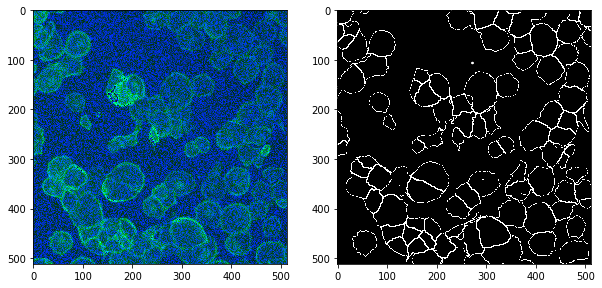

In [270]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10, 8))
plt.subplot('121')
im = imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)

plt.subplot('122')
mask = imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray');

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from torch.optim import lr_scheduler

from torchvision import transforms as Transforms
from torchvision.transforms import functional as TF

from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [272]:
!lscpu
if torch.cuda.is_available():
    print("\n Nvidia %s" % torch.cuda.get_device_name())

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2300.000
BogoMIPS:            4600.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single pti ssbd i

In [0]:
folders = {
    'dataset': Path('BBBC018_v1_images-fixed'), 
    'targets': Path('BBBC018_v1_outlines')
}

def extract_images(mode):
    """
    param: mode - str object (one of 'train', 'val', 'test')
    """
    path_to_img = folders['dataset'] / mode
    img_names = sorted(list(path_to_img.iterdir()))
    images = np.array([imread(str(x)) for x in img_names])
    
    if mode != 'test':
        path_to_msk = folders['targets'] / mode
        msk_names = sorted(list(path_to_msk.iterdir()))
        masks  = np.array([imread(str(x)) for x in msk_names])
        
        return images, masks
    
    return images

In [0]:
class ImgSet(data_utils.Dataset):
    def __init__(self, imgs, msks, transform=None):
        self.imgs = imgs
        self.msks = msks
        
        self.trfm = transform
                    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, ix):
        img = self.imgs[ix]
        msk = self.msks[ix]
        if self.trfm:
            img, msk = self.trfm(img, msk)

        return [img, msk]

In [275]:
N_tr  = len(list(Path('BBBC018_v1_images-fixed/train').iterdir()))
N_val = len(list(Path('BBBC018_v1_images-fixed/val').iterdir()))
N_te  = len(list(Path('BBBC018_v1_images-fixed/test').iterdir()))

print("Number of train objects: \t%i" % N_tr)
print("Number of val objects: \t\t%i" % N_val)
print("Number of test objects: \t%i" % N_te)

Number of train objects: 	41
Number of val objects: 		7
Number of test objects: 	7


In [0]:
# original code: https://gist.github.com/oeway/2e3b989e0343f0884388ed7ed82eb3b0
def elastic_transform(image, alpha=1000, sigma=30, 
                      mode='nearest', seed=666):
    """Elastic deformation of image as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    np.random.seed(seed)
    dims = image.ndim
    
    shape = image.shape[:-1] if dims > 2 else image.shape
    
    dx = gaussian_filter(
        np.random.rand(*shape) * 2 - 1,
        sigma, mode="constant", cval=0
    ) * alpha
    
    dy = gaussian_filter(
        np.random.rand(*shape) * 2 - 1,
        sigma, mode="constant", cval=0
    ) * alpha

    x, y = np.meshgrid(
        np.arange(shape[0]), 
        np.arange(shape[1]), 
        indexing='ij'
    )
    
    indices = [
        np.reshape(x + dx, (-1, 1)), 
        np.reshape(y + dy, (-1, 1))
    ]
    
    result = np.empty_like(image)
    
    if dims > 2:
        # image
        for i in range(image.shape[-1]):
            result[:, :, i] = map_coordinates(
                image[:, :, i], indices, order=1, mode=mode
            ).reshape(shape)
            
        return result
    

    # mask
    result = map_coordinates(
        image, indices, order=1
    ).reshape(shape)

    return (result > 0).astype('float32')

In [0]:
class Compose(Transforms.Compose):
    def __call__(self, img, msk):
        for t in self.transforms:
            img, msk = t(img,msk)
        return img, msk

class RandomCrop(Transforms.RandomCrop):
    def __call__(self, img, msk):
        i, j, h, w = super().get_params(
            img, self.size
        )
        img = TF.crop(img, i, j, h, w)
        msk = TF.crop(msk, i, j, h, w)

        return img, msk

class RandomFlip:
    def __init__(self, dim, p=.5):
        self.p = p
        self.dim = dim

    def __call__(self, img, msk):
        if np.random.random() < self.p:
            if self.dim:
                img = TF.hflip(img)
                msk = TF.hflip(msk)
            else:
                img = TF.vflip(img)
                msk = TF.vflip(msk)

        return img, msk

class ColorJitter(Transforms.ColorJitter):
    def __call__(self, img, msk):
        img = super().__call__(img)

        return img, msk

class RandomRotation:
    def __init__(self, lim, p=.5):
        assert lim >= 0, 'lim must be positive'
        self.p = p
        self.lim = lim
        
    def __call__(self, img, msk):
        if np.random.random() < self.p:
            angle = np.random.randint(-self.lim, self.lim)
            img = TF.rotate(img, angle)
            msk = TF.rotate(msk, angle)

        return img, msk

class ToPILImage(Transforms.ToPILImage):
    def __call__(self, img, msk):
        img = TF.to_pil_image(img)
        msk = TF.to_pil_image(msk)

        return img, msk

class ToTensor:
    def __call__(self, img, msk):
        img = TF.to_tensor(img)
        msk = TF.to_tensor(msk)
        return img, msk
    
class ElasticDistortion:
    CNT = np.random.randint(1e5)
    def __init__(self, mid=20, var=5, p=.5):
        self.p = p
        assert 0 <= p <= 1, 'p must be in [0, 1]'
        assert var > 0, 'var must be positive'
        assert mid > 0, 'mid must be positive'
        self.mid = mid
        self.var = var
    
    def __call__(self, img, msk):
        if np.random.random() < self.p:
            s = self.mid + np.random.randint(-self.var, self.var)
            img = elastic_transform(img, sigma=s, seed=self.CNT)
            msk = elastic_transform(msk, sigma=s, seed=self.CNT)
            self.CNT += 1
        
        return img, msk


transforms = {
    'train' : Compose([
        ElasticDistortion(32),
        ToPILImage(),
        RandomFlip(0),
        RandomFlip(1),
        RandomRotation(10),
        RandomCrop(160),
        ColorJitter(brightness=.2, contrast=.2),
        ToTensor(),
    ]),
    'val' : ToTensor()
}

In [0]:
data = {x: extract_images(x) for x in ['train', 'val', 'test']}

image_datasets = {x: ImgSet(*data[x], transforms[x]) 
                         for x in  ['train', 'val']}

data_loaders = {x: data_utils.DataLoader(
    image_datasets[x], batch_size=n, shuffle=y, num_workers=2
    ) for x, y, n in zip(['train', 'val'], [True, False], [32, 1])}

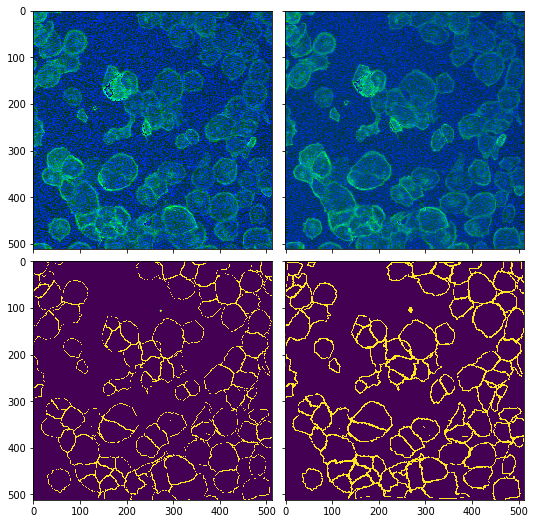

In [396]:
# Elastic transform in action
X = data['train'][0][0]
y = data['train'][1][0]

s = 30
Xm = elastic_transform(X, sigma=s)
ym = elastic_transform(y, sigma=s)

fig, ax = plt.subplots(2, 2, True, True, figsize=(9, 9))
fig.subplots_adjust(wspace=.01, hspace=.05)
for i, img in enumerate([X, Xm, y, ym]):
    ax[i // 2, i % 2].imshow(img)

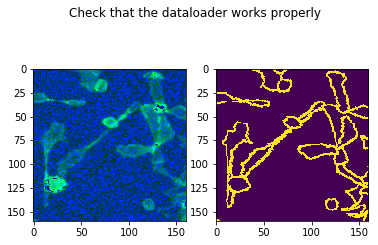

In [462]:
for batch_i, batch_m in data_loaders['train']:
    img = TF.to_pil_image(batch_i[0])
    msk = TF.to_pil_image(batch_m[0])
    plt.subplot('121')
    plt.imshow(img)
    plt.subplot('122')
    plt.imshow(msk)
    break
    
fig = plt.gcf()
fig.suptitle("Check that the dataloader works properly");

In [463]:
ones  = torch.tensor(0.)
total = torch.tensor(0.)

img_set, msk_set = data['train']
for _, msks in data_utils.DataLoader(ImgSet(img_set, msk_set, ToTensor()), 24):
    ones  += torch.sum(msks)
    total += msks.numel()
    
pos_weight = torch.tensor([(total - ones).float() / ones]).to(device)
print(pos_weight)

tensor([24.6579], device='cuda:0')


In [0]:
# let's take an existing net as a stencil 
# and modify it where it is needed
# original version: 
# https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(
            in_channels, out_channels, 
            3, padding=1, bias=False
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout(.1), # read docs about Dropout and Dropout2d
        nn.Conv2d(
            out_channels, out_channels, 
            3, padding=1, bias=False
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout(.1) # read docs about Dropout and Dropout2d
    )   

class UNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample1 = nn.ConvTranspose2d(512, 512, 2, 2)
        self.upsample2 = nn.ConvTranspose2d(256, 256, 2, 2)
        self.upsample3 = nn.ConvTranspose2d(128, 128, 2, 2)
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, 1, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample1(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample2(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample3(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [0]:
def train_model(model, dataloaders, criterion, 
                optimizer, scheduler, num_epochs=25):

    train_history = []
    val_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_score = np.inf
    memo_epoch = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval()

            running_loss = 0.

            for imgs, msks in dataloaders[phase]:
                imgs = imgs.to(device)
                msks = msks.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                     
                    outs = model(imgs)
                    loss = criterion(outs, msks)
                        
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * imgs.size(0)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            if phase == 'val' and epoch_loss < best_score:
                best_score = epoch_loss
                memo_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_history.append(epoch_loss)
            else:
                train_history.append(epoch_loss)

    print('\nBest Val Score: {:4f} is on epoch {}'.format(best_score, memo_epoch))

    model.load_state_dict(best_model_wts)
    return model, train_history, val_history

In [0]:
model = UNet()
model = model.to(device)
optimizer = optim.RMSprop(model.parameters(), lr=2e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.9)
criterion = nn.BCEWithLogitsLoss(weight = pos_weight)

In [467]:
%%time
model, train_history, val_history = train_model(model, 
                                                data_loaders, 
                                                criterion, 
                                                optimizer,
                                                scheduler,
                                                num_epochs=300
                                               )

Epoch 1/300
----------
train Loss: 16.1644
val Loss: 17.9211
Epoch 2/300
----------
train Loss: 15.1119
val Loss: 17.4807
Epoch 3/300
----------
train Loss: 14.0472
val Loss: 17.1298
Epoch 4/300
----------
train Loss: 12.7840
val Loss: 16.0902
Epoch 5/300
----------
train Loss: 11.8869
val Loss: 14.1904
Epoch 6/300
----------
train Loss: 11.1159
val Loss: 12.0776
Epoch 7/300
----------
train Loss: 10.6337
val Loss: 10.6335
Epoch 8/300
----------
train Loss: 10.0231
val Loss: 9.9392
Epoch 9/300
----------
train Loss: 9.5025
val Loss: 8.9143
Epoch 10/300
----------
train Loss: 9.2329
val Loss: 9.1623
Epoch 11/300
----------
train Loss: 9.0546
val Loss: 9.9474
Epoch 12/300
----------
train Loss: 8.7372
val Loss: 9.6623
Epoch 13/300
----------
train Loss: 8.5388
val Loss: 8.6454
Epoch 14/300
----------
train Loss: 8.1499
val Loss: 8.4560
Epoch 15/300
----------
train Loss: 7.9044
val Loss: 8.9951
Epoch 16/300
----------
train Loss: 7.5828
val Loss: 9.1332
Epoch 17/300
----------
train Loss

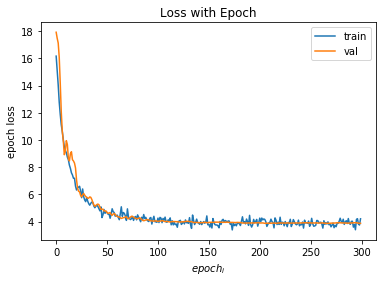

In [468]:
plt.plot(train_history, label='train')
val_history = np.array(val_history)
val_history = val_history[np.where(val_history < 18)]
plt.plot(val_history, label='val')
plt.title("Loss with Epoch")
plt.xlabel(r'$epoch_i$')
plt.ylabel('epoch loss')
plt.legend();

In [0]:
def calc_iou(prediction, ground_truth, threshold):
    intersection = np.logical_and(
        prediction > threshold, ground_truth > 0
    ).sum() 

    union = np.logical_or(
        prediction > threshold, ground_truth > 0
    ).sum()
        
    return float(intersection) / union

In [0]:
val_tensors = torch.FloatTensor([
    np.transpose(x / 255, (2, 0, 1))
    for x in data['val'][0]
]).to(device)

In [0]:
val_masks = model(val_tensors).squeeze() \
                              .sigmoid() \
                              .detach()  \
                              .cpu()     \
                              .numpy()

In [490]:
# it's hard to reproduce the same results
# basically, you will have to tune threshold manually
threshold = .261
print("Intersection-over-Union Metric")
calc_iou(val_masks, data['val'][1], threshold)

Intersection-over-Union Metric


0.25495952943542305

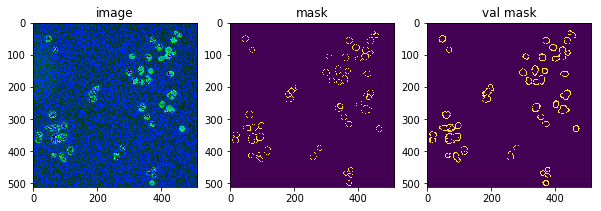

In [491]:
plt.figure(figsize=(10,8));

plt.subplot('131');
plt.imshow(data['val'][0][1]);
plt.title('image')

plt.subplot('132');
plt.imshow(data['val'][1][1]);
plt.title('mask')

plt.subplot('133');
plt.imshow(val_masks[1] > threshold);
plt.title('val mask');


In [0]:
test_tensors = torch.FloatTensor([
    np.transpose(x / 255, (2, 0, 1)) 
    for x in data['test']
]).to(device)

In [0]:
test_preds = model(test_tensors).squeeze() \
                                .sigmoid() \
                                .detach()  \
                                .cpu()     \
                                .numpy()

	 RESULTS ON THE TEST DATASET


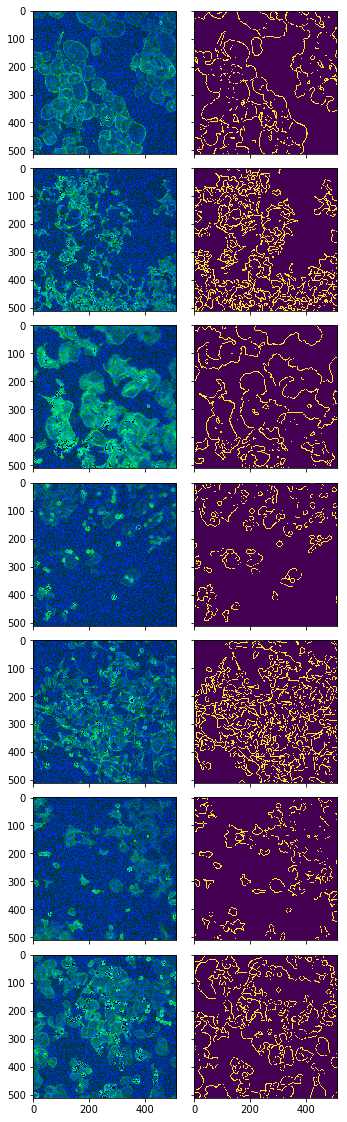

In [494]:
fig, ax = plt.subplots(7, 2, True, True, figsize=(16, 20))
fig.subplots_adjust(wspace=-.78, hspace=.1)
for i, (img, msk) in enumerate(zip(data['test'], test_preds > threshold)):
    ax[i,0].imshow(img)
    ax[i,1].imshow(msk)
print("\t RESULTS ON THE TEST DATASET");

## Some Conclusions:
"is worse than"  = " < "

- Rotations at all angles < rotations at an angle in [-45, 45) < rotations at an angle in [-90, 90) < ..__.. [-10, 10) (strange or I've missed sth)
- The smaller the size of a crop, the greater number of of "empty crops", where there are no cancer cells - not good for the network expressiveness (we cannot distinguish empty images). At the same time, the closer the size of a crop to the original images size, the smaller the variations in the data (losing augmented data). So we should find the middle ground
- Class weights also matter. I tested small coeff-s (like 3, 5, 7), they didn't do well. `pos_weight` average class ration is good. Possibly, it may be better with further fine-tunning (I set `2/3 * pos_weight` and once it gave the result)

**Brief history** of the improvements made:
- First trial ~ 0.06 iou  
- Add rotations    + 0.03  
- Increase number of epochs    + 0.03  
- Add BNs and Dropouts    + 0.03  
- Change nn.Upsample for nn.ConvTranspose2d    + 0.02  
- Add elastic distortion    + 0.02  
- Remove transformations from val dset    + 0.03  
- SGD <? Adam < RMSprop + 0.015?
- There was sth else, I don't remember  
(The values are not exact, but close to that, give or take)  